# Preliminary analysis of the dataset

In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

import utils
import os

import glob
import random

%matplotlib inline

## Visualization of the images

Observatory,
Instrument,
Detector,
Measurement,Unknown
Wavelength,Unknown
Observation Date,2015-12-28 03:16:41
Exposure Time,Unknown
Dimension,[256. 256.] pix
Coordinate System,helioprojective
Scale,[0.00266984 0.00266984] deg / pix
Reference Pixel,[127.08625031 127.05374906] pix

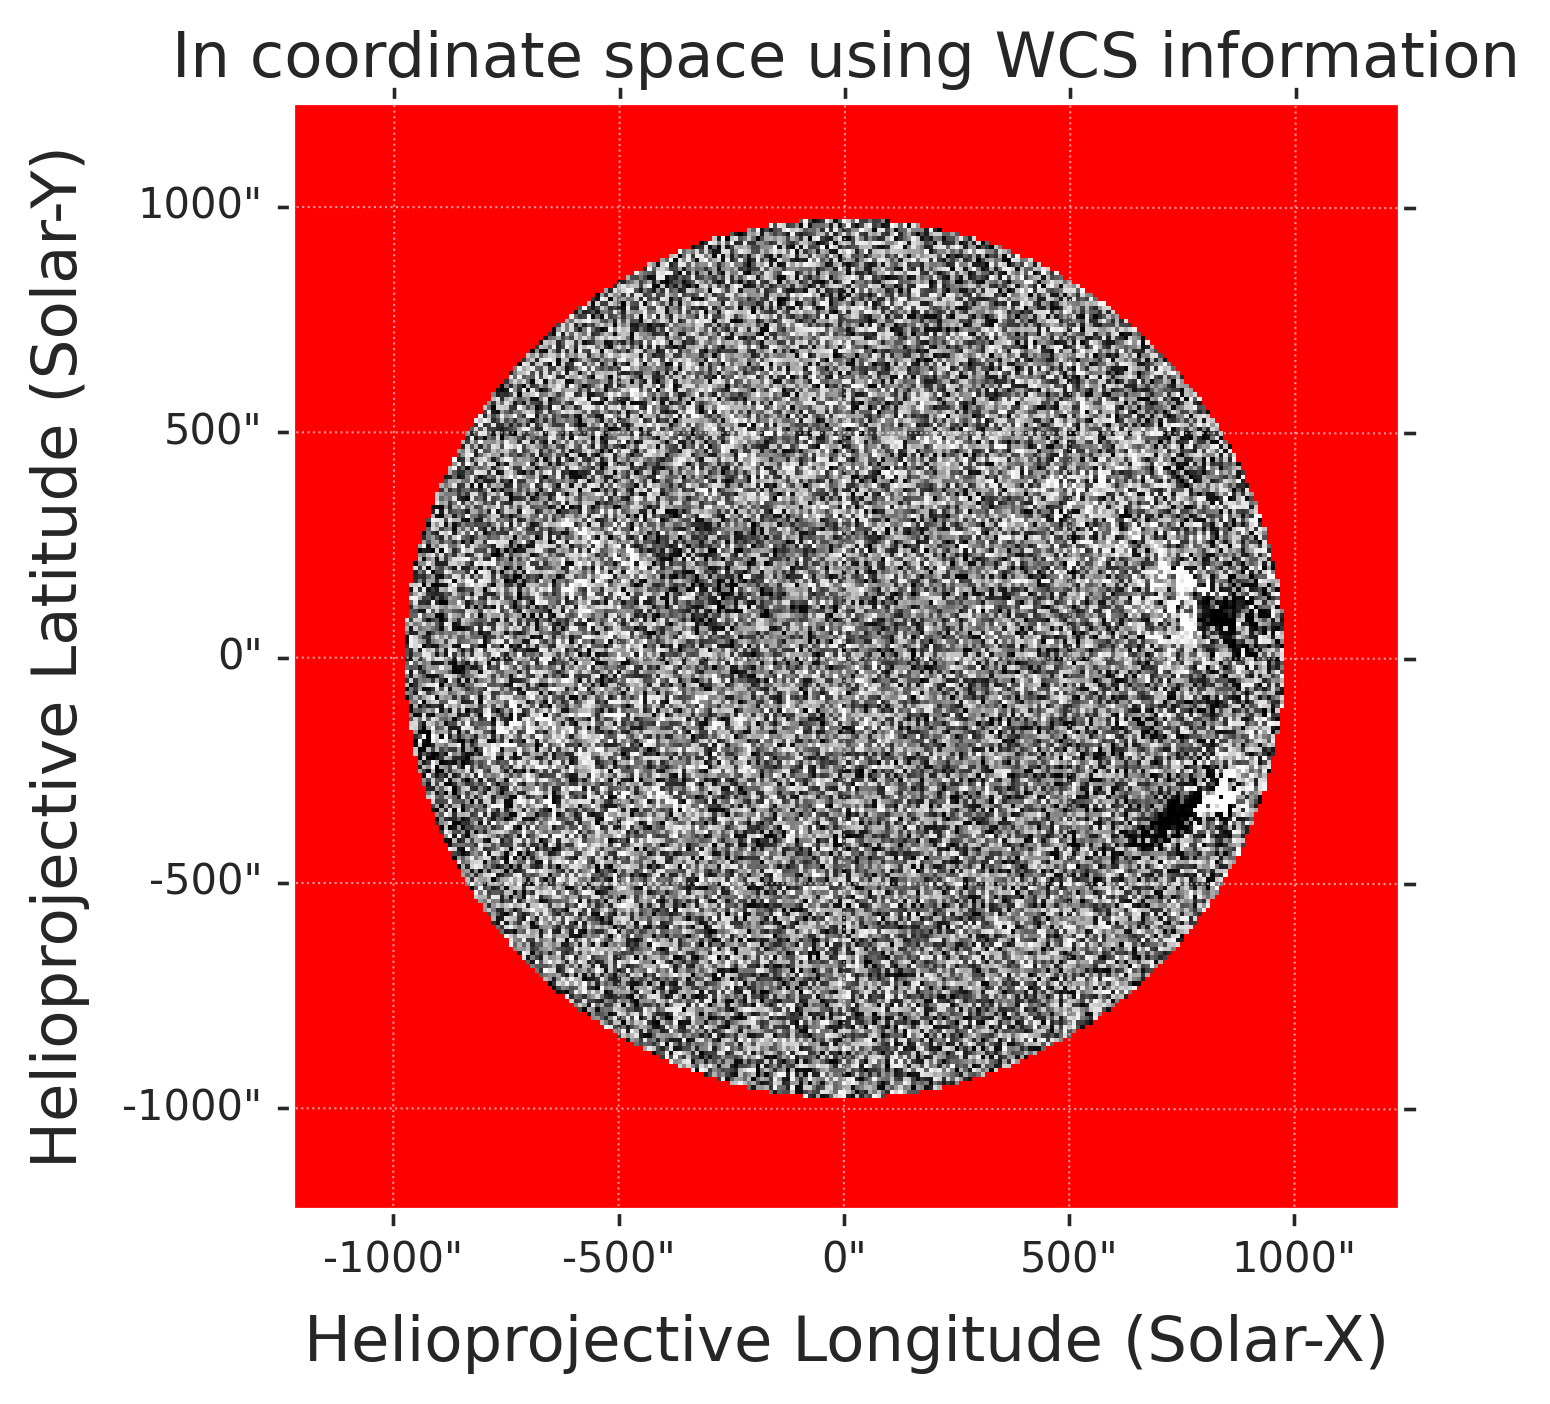
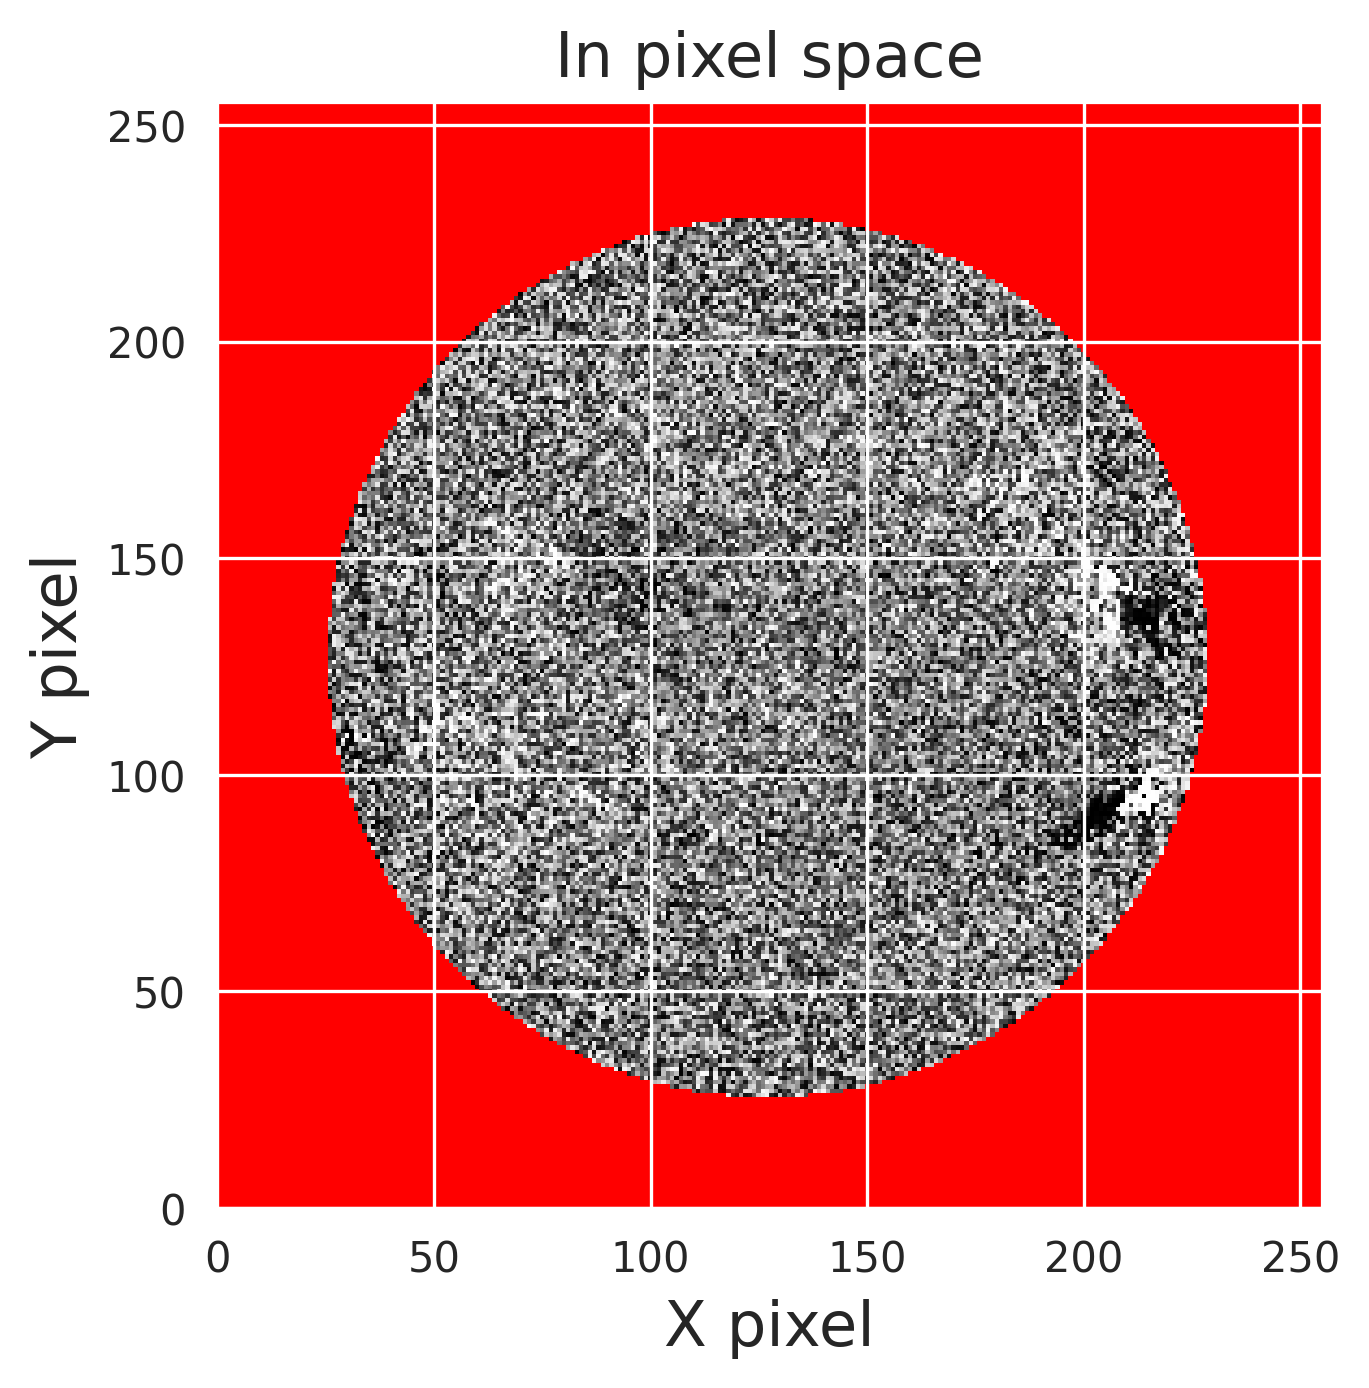
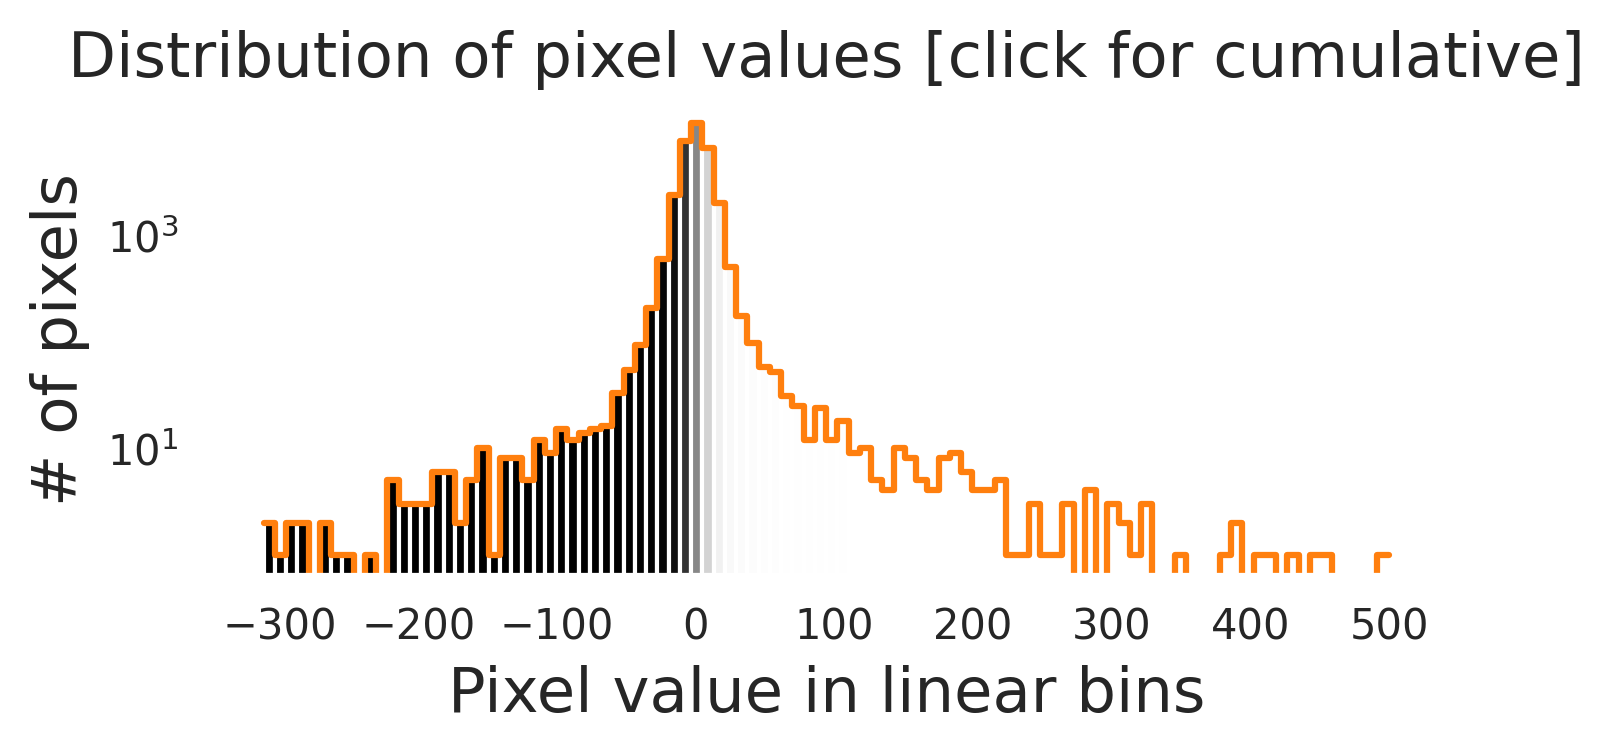
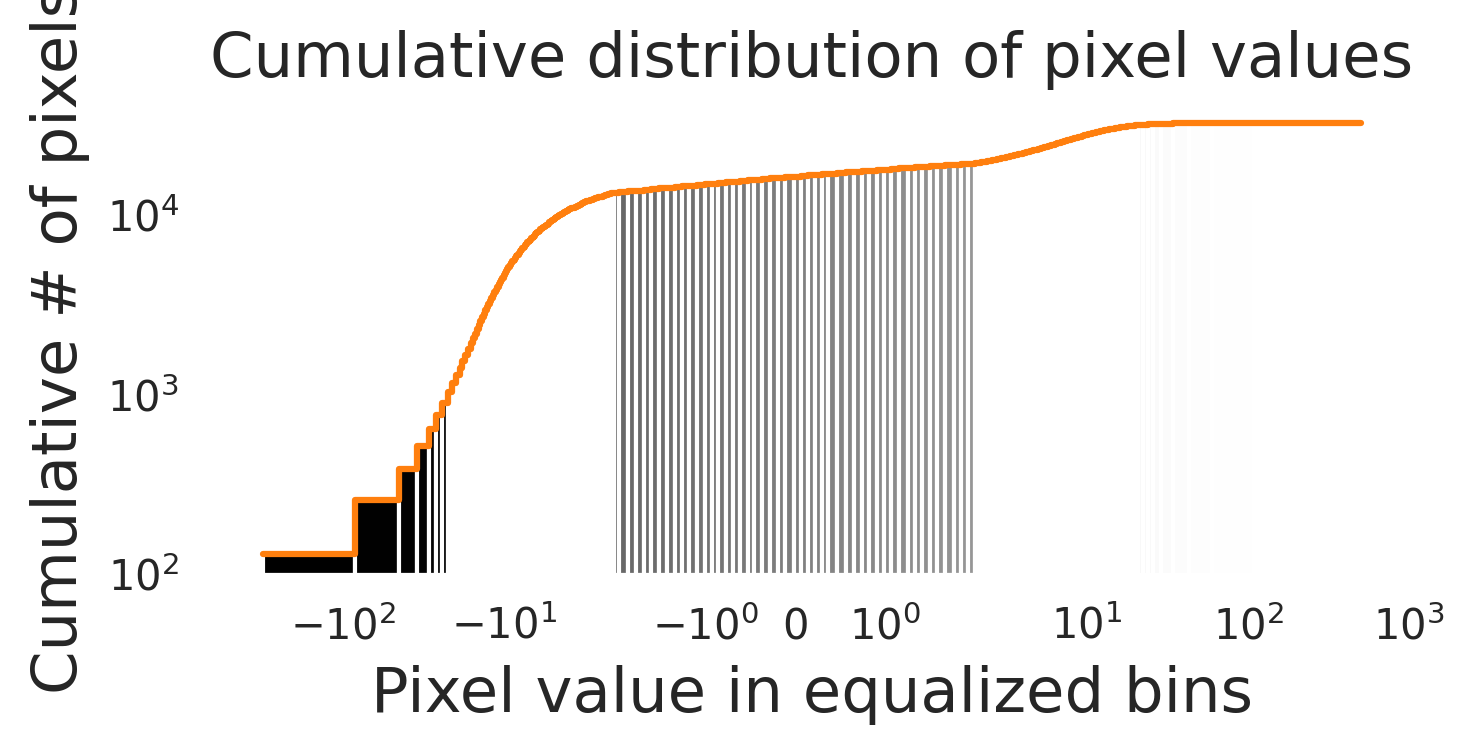

In [2]:
HMIm_2016 = sunpy.map.Map("data/hmi_magnetogram/2016*.fits")
HMIm_2016[0]

In [3]:
HMIm_2016_matrix = np.array(list(d.data for d in HMIm_2016))
HMIm_2016_matrix.shape

(2908, 256, 256)

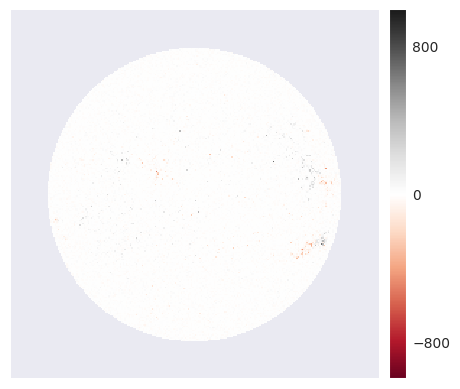

In [4]:
aia211_colormap = cm.color_tables.aia_color_table(211*u.angstrom)
isns.imshow(HMIm_2016_matrix[1], cmap="RdGy", vmin=-1000, vmax=1000)
plt.show()

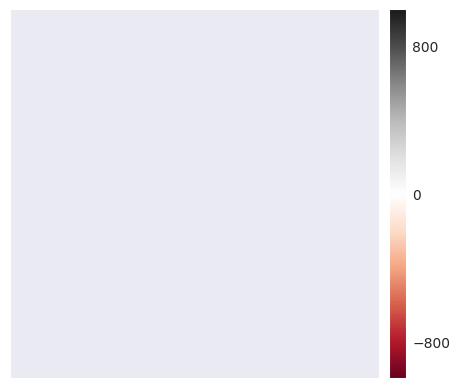

In [5]:
isns.imshow(HMIm_2016_matrix[188], cmap="RdGy", vmin=-1000, vmax=1000)
plt.show()

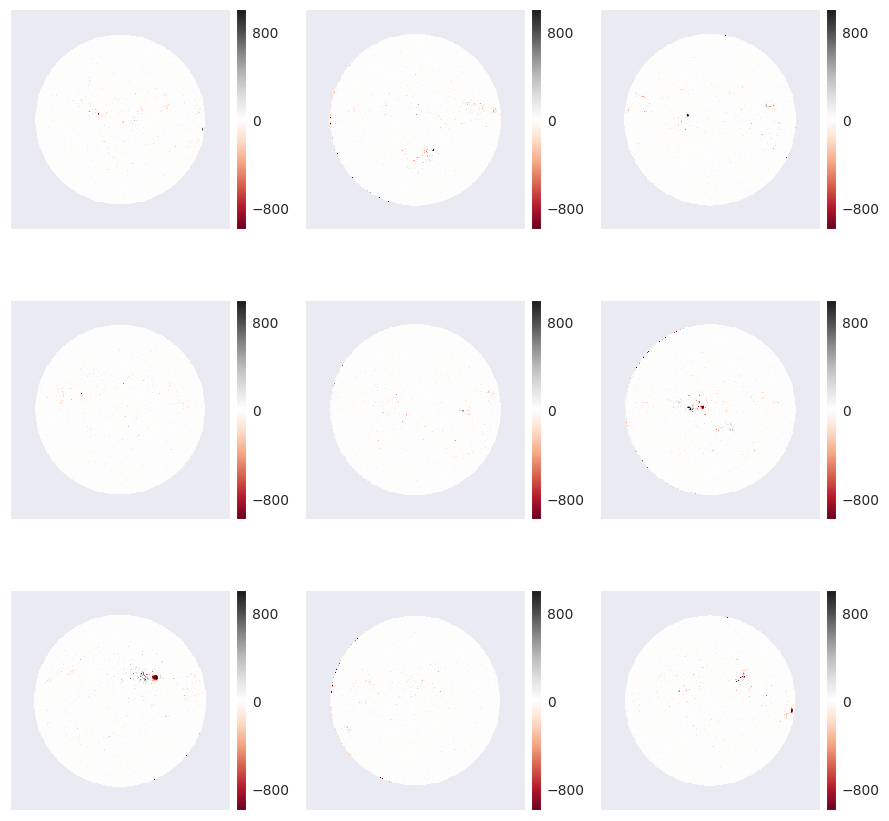

In [6]:
isns.ImageGrid(random.sample(list(HMIm_2016_matrix), 9), cmap="RdGy", vmin=-1000, vmax=1000)

## Normalization

In [7]:
print(utils.range_tuple(HMIm_2016_matrix))
print(utils.range_tuple(HMIm_2016_matrix[188]))

(-4907.892314891231, 4930.260969088896)
(nan, nan)


/home/eugeniolr/Documents/master/TFM/utils.py:28: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(matrix), np.nanmax(matrix)


In [8]:
# min_values = AIA211_2016_matrix.min(axis=2, keepdims=True).min(axis=1, keepdims=True)
# print(min_values.shape)

max_values = np.nanmax(np.nanmax(np.abs(HMIm_2016_matrix), axis=2, keepdims=True), axis=1, keepdims=True)
print(max_values.shape)

(2908, 1, 1)


/tmp/ipykernel_25669/3121585123.py:4: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(np.abs(HMIm_2016_matrix), axis=2, keepdims=True), axis=1, keepdims=True)


In [9]:
HMIm_2016_mnorm = HMIm_2016_matrix / max_values
utils.range_tuple(HMIm_2016_mnorm)

(-1.0, 1.0)

# Comparison between the histogram of a good image and a noisy image

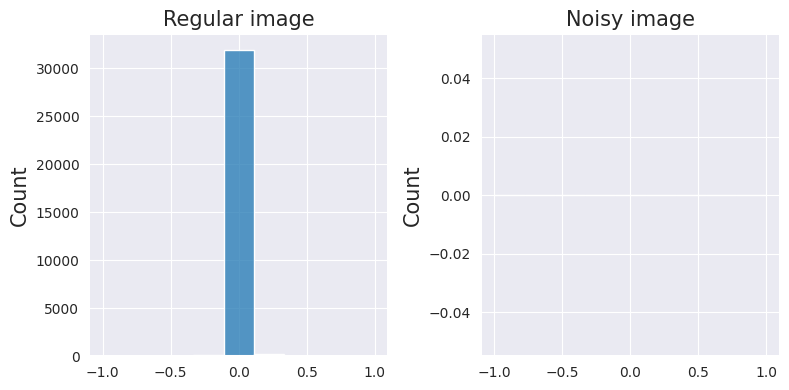

In [10]:
nbins = 10

fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 4]))

sns.histplot(HMIm_2016_mnorm[0].flatten(), bins=np.linspace(-1,1,nbins), ax=axes[0]).set(title="Regular image")

p = sns.histplot(HMIm_2016_mnorm[188].flatten(), bins=np.linspace(-1,1,nbins), ax=axes[1]).set(title="Noisy image")

fig.tight_layout()

## Noise detection model with kmeans

In [35]:
hist_vectors = np.array([np.histogram(i.flatten(), bins=np.linspace(-1,1,nbins))[0] for i in HMIm_2016_mnorm])

In [36]:
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans.fit(hist_vectors)
kmeans

KMeans(n_clusters=2)

### Visualization of each class

(2896, 256, 256)
(12, 256, 256)


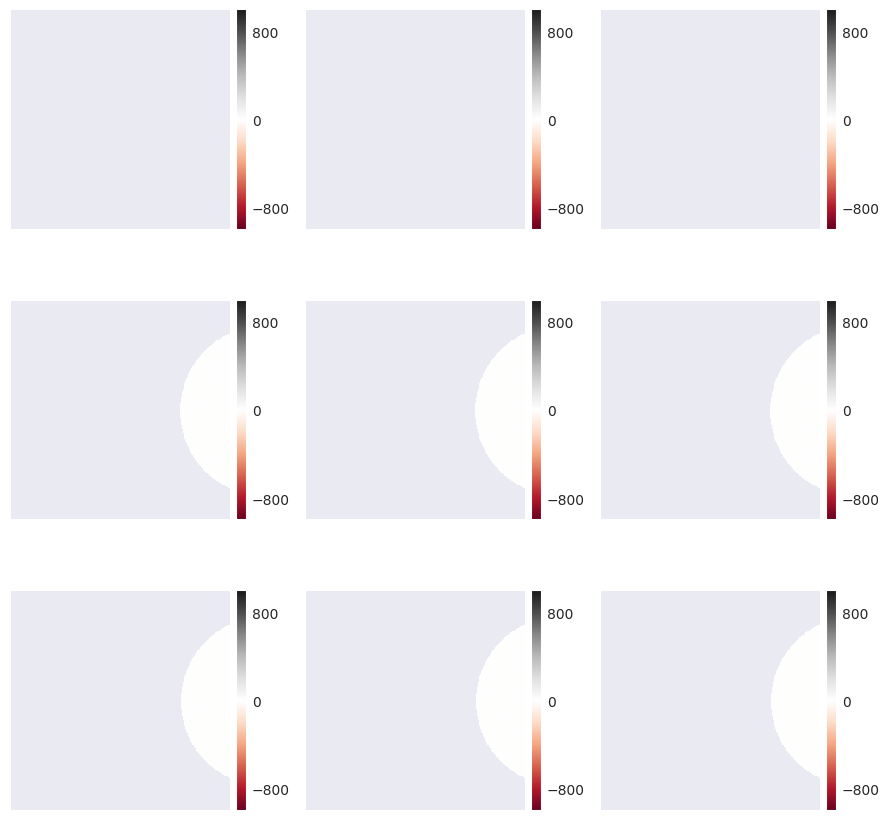

In [37]:
class1 = HMIm_2016_mnorm[kmeans.labels_ == kmeans.labels_[0], :, :]  # since we know the first image is not noise
class2 = HMIm_2016_mnorm[kmeans.labels_ != kmeans.labels_[0], :, :]
print(class1.shape)
print(class2.shape)
isns.ImageGrid([i for i in class2[:9]], cmap="RdGy", vmin=-1000, vmax=1000)
plt.show()

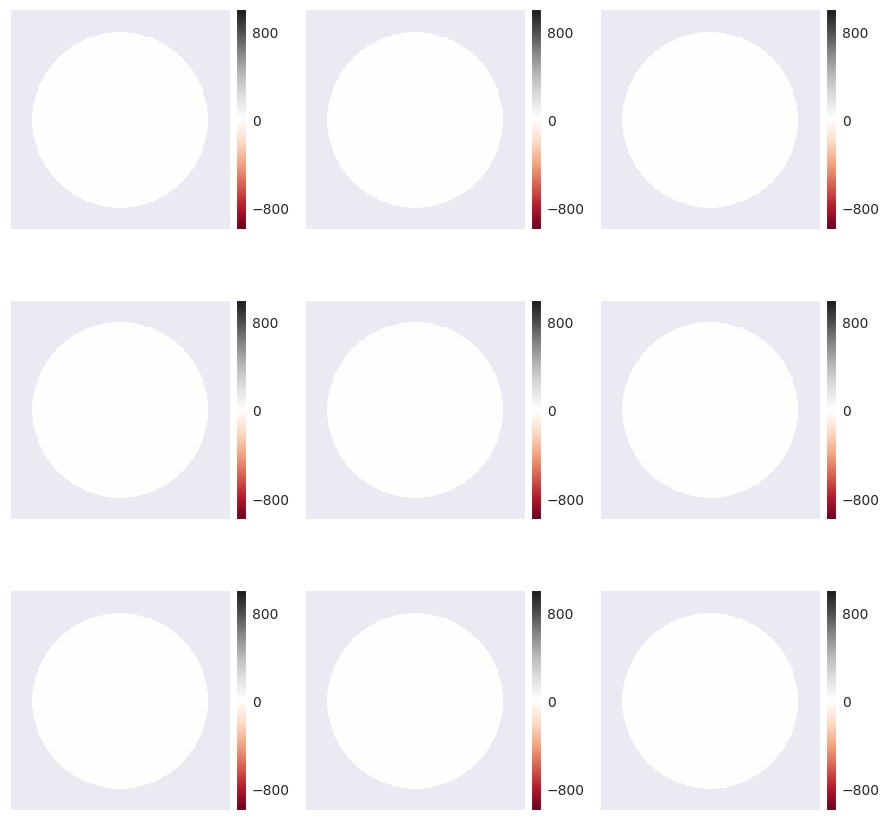

In [38]:
isns.ImageGrid([i for i in class1[:9]], cmap="RdGy", vmin=-1000, vmax=1000)
plt.show()

## We use the model to identify noisy images in the datase

In [42]:
file_list = []
kmeans_list = []

year_list = set(map(lambda x: x[:4], os.listdir("data/hmi_magnetogram")))

for year in year_list: 
    img_file_list = glob.glob(f"data/hmi_magnetogram/{year}*.fits")
    img_list = sunpy.map.Map(img_file_list)
    img_matrix = np.array(list(map(lambda x: x.data, img_list)))

    max_values = np.nanmax(np.nanmax(np.abs(img_matrix), axis=2, keepdims=True), axis=1, keepdims=True)

    img_norm = img_matrix / max_values
    img_flat_array = img_norm.reshape([img_norm.shape[0], img_norm.shape[1]*img_norm.shape[2]])
    for j, img_flat in enumerate(img_flat_array):
        hist_array, _ = np.histogram(img_flat, bins=np.linspace(-1,1,nbins))
        k = kmeans.predict(hist_array.reshape([1, -1]))[0]
        kmeans_list.append(k)
        if k != kmeans.labels_[0]:
            print(img_file_list[j])
            file_list.append(img_file_list[j])


/tmp/ipykernel_25669/1661654905.py:11: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(np.abs(img_matrix), axis=2, keepdims=True), axis=1, keepdims=True)


(754, 256, 256)
data/hmi_magnetogram/2012-10-17T12-01-30.fits
data/hmi_magnetogram/2012-10-22T21-01-30.fits
data/hmi_magnetogram/2012-10-24T18-01-30.fits
data/hmi_magnetogram/2012-10-22T18-01-30.fits
data/hmi_magnetogram/2012-10-24T12-01-30.fits
data/hmi_magnetogram/2012-12-06T15-01-30.fits
data/hmi_magnetogram/2012-10-17T16-03-00.fits
data/hmi_magnetogram/2012-10-16T15-01-30.fits
data/hmi_magnetogram/2012-12-06T21-01-30.fits
data/hmi_magnetogram/2012-10-19T18-01-30.fits
data/hmi_magnetogram/2012-10-18T21-01-30.fits
data/hmi_magnetogram/2012-10-14T15-01-30.fits
data/hmi_magnetogram/2012-10-22T15-01-30.fits
data/hmi_magnetogram/2012-10-25T18-01-30.fits
data/hmi_magnetogram/2012-10-23T12-01-30.fits
data/hmi_magnetogram/2012-10-14T09-01-30.fits
data/hmi_magnetogram/2012-10-19T12-01-30.fits
data/hmi_magnetogram/2012-12-07T15-01-30.fits
data/hmi_magnetogram/2012-12-07T18-01-30.fits
data/hmi_magnetogram/2012-10-26T18-01-30.fits
data/hmi_magnetogram/2012-12-10T15-01-30.fits
data/hmi_magnetogr

### A sample of noisy images

In [33]:
img_file_list = random.choices(file_list, k=12)
img_list = sunpy.map.Map(img_file_list)
img_matrix = np.array(list(map(lambda x: x.data, img_list)))

max_values = img_matrix.max(axis=2, keepdims=True).max(axis=1, keepdims=True)

img_norm = img_matrix / max_values

isns.ImageGrid([i for i in img_norm], cmap=aia211_colormap, col_wrap=4)
plt.show()

IndexError: list index out of range

In [ ]:
with open("noisy_HMI_m.csv", "w") as nf:
    for i in file_list:
        nf.write(i)
        nf.write("\n")